# Stress Testing Trading Strategy Framework with TimeGAN

# Data Loading and Adding Features

Load dataset from yfinance

- data_name: ^GSPC, AAPL, GOOG, AMZN, MSFT
- start_date: date from which we want data
- end_date: date till which we want data

Add 6 extra features to data in addition to Adj Close, Close, High, Low, Open, Volume

- Log_Return: log returns
- ATR: Average True Range
- BBW: Bollinger Band Width
- MACD: main line for Moving Average Convergence Divergence
- MACD_Signal: signal line for Moving Average Convergence Divergence
- RSI: Relative Strength Index


Functions called:

- real_data_loading

In [2]:
from data_loading import real_data_loading

In [3]:
# --- Data loading ---
data_name = "AAPL"
seq_len = 60
start_date = "2005-01-01"
end_date = "2024-11-10"

ori_data = real_data_loading(data_name, start_date, end_date)

print(f"{data_name} dataset is ready. Number of sequences: {len(ori_data)}")

AAPL dataset is ready. Number of sequences: 4979


In [4]:
print(ori_data.head())

all_names = ori_data.columns.get_level_values(0)
feature_names= all_names.tolist()
print(feature_names)

Price      Adj Close     Close      High       Low      Open      Volume  \
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL        AAPL   
Date                                                                       
2005-01-31  1.153155  1.373214  1.390893  1.330536  1.331786  1681097600   
2005-02-01  1.162603  1.384464  1.388750  1.367500  1.375893   678395200   
2005-02-02  1.194093  1.421964  1.426964  1.387321  1.391964  1020062400   
2005-02-03  1.166802  1.389464  1.418393  1.380893  1.412500   731651200   
2005-02-04  1.182247  1.407857  1.409464  1.384464  1.390536   563556000   

Price      Log_Return       ATR       BBW      MACD MACD_Signal        RSI  
Ticker                                                                      
Date                                                                        
2005-01-31   0.038711  0.043237  0.214918  0.047071    0.036300  88.590696  
2005-02-01   0.008159  0.040306  0.222039  0.051872    0.039414  89.490280  
2005-0

# Data Preprocessing

- seq_len: sequence length of the time-series data

Functions called:

- real_data_processing

In [5]:
from data_loading import real_data_processing

In [6]:
# --- Data Processing ---
ori_data_x = real_data_processing(ori_data, seq_len)
print(len(ori_data_x))
print(ori_data_x[0].shape)

4919
(60, 12)


# Data Labelling

Labelling each of the ori_data_x[i] as Normal, Crisis, or Volatile, and storing them in ori_data_s. Basically ori_data_s[i] will act as static feature for the corresponding ori_data_x[i].

Each of these market conditions are of one-hot vector form.

- Normal: [1.0, 0.0, 0.0]
- Crisis: [0.0, 1.0, 0.0]
- Volatile: [0.0, 0.0, 1.0]

Functions called:

- label_data

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

from data_loading import label_data

Labeling complete using fixed thresholds.

--- Labeling Results ---
Final Label Distribution:
label
Normal      48.2%
Crisis      29.6%
Volatile    22.2%
Name: proportion, dtype: object

Total length of 'ori_data': 4919
Total length of 'ori_data_s': 4919

Generating visualization of labeled clusters...
Saved cluster visualization to 'market_regime_clusters.png'


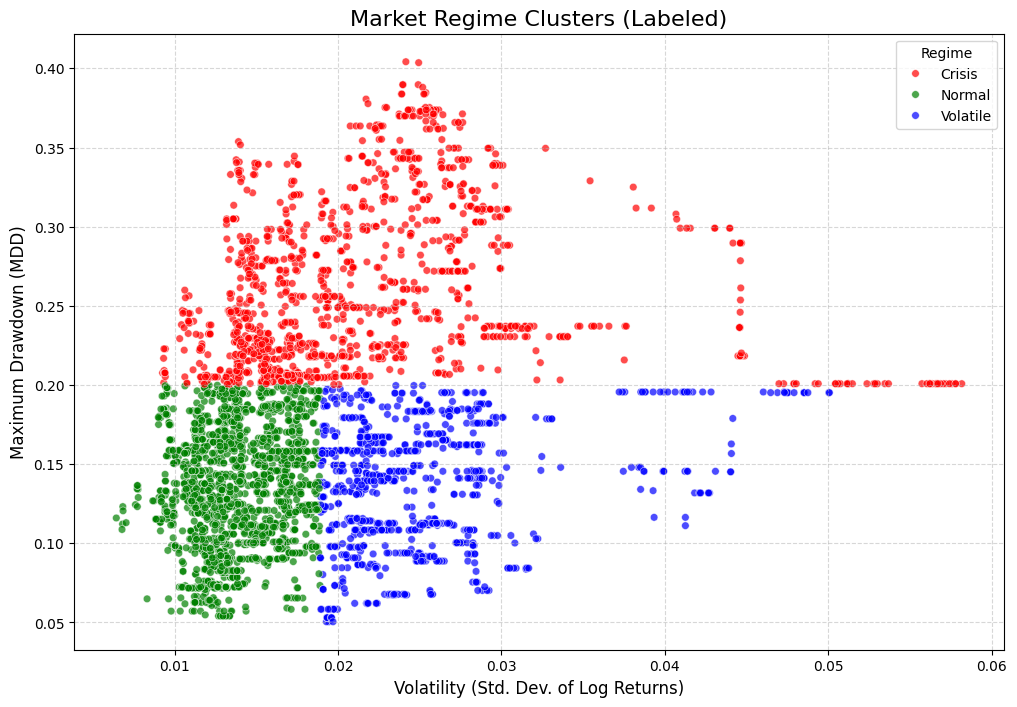

In [8]:
# Run the labeling function
ori_data_s, metrics_df = label_data(ori_data_x, feature_names)

# --- Check the results ---
if ori_data_s:
    print(f"\nTotal length of 'ori_data': {len(ori_data_x)}")
    print(f"Total length of 'ori_data_s': {len(ori_data_s)}")

    # --- Visualization ---
    print("\nGenerating visualization of labeled clusters...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=metrics_df,
        x='volatility',
        y='mdd',
        hue='label',
        palette={'Normal': 'g', 'Volatile': 'b', 'Crisis': 'r'},
        alpha=0.7,
        s=30
    )
    plt.title('Market Regime Clusters (Labeled)', fontsize=16)
    plt.xlabel('Volatility (Std. Dev. of Log Returns)', fontsize=12)
    plt.ylabel('Maximum Drawdown (MDD)', fontsize=12)
    plt.legend(title='Regime')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("market_regime_clusters.png")
    print("Saved cluster visualization to 'market_regime_clusters.png'")

# TimeGAN implementation

TimeGAN uses the original data with its static features and network parameters to return the generated synthetic data with its static features.

In [9]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
from timegan import generate_data_from_saved_models
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

2025-11-13 22:19:29.417098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 22:19:30.288274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 22:19:33.802431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [10]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru'
parameters['hidden_dim'] = 32
parameters['num_layer'] = 3
parameters['iterations'] = 8000
parameters['batch_size'] = 128

## Run TimeGAN for synthetic time-series data generation

Train the network Models and save them in saved_models

Functions called:

- timegan

In [11]:
# Train Timegan
timegan(ori_data_s, ori_data_x, parameters)

2025-11-13 22:19:35.434675: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Start Embedding Network Training
step: 0/8000, e_loss: 0.5989999771118164
step: 1000/8000, e_loss: 0.07280000299215317
step: 2000/8000, e_loss: 0.03539999946951866
step: 3000/8000, e_loss: 0.02239999920129776
step: 4000/8000, e_loss: 0.01360000018030405
step: 5000/8000, e_loss: 0.010499999858438969
step: 6000/8000, e_loss: 0.009399999864399433
step: 7000/8000, e_loss: 0.008500000461935997
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, s_loss: 0.18709999322891235
step: 1000/8000, s_loss: 0.023600000888109207
step: 2000/8000, s_loss: 0.020500000566244125
step: 3000/8000, s_loss: 0.019099999219179153
step: 4000/8000, s_loss: 0.017899999395012856
step: 5000/8000, s_loss: 0.017899999395012856
step: 6000/8000, s_loss: 0.01730000041425228
step: 7000/8000, s_loss: 0.016899999231100082
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, d_loss: 4.2993998527526855, g_loss_u: 1.2882000207901, g_loss_s: 0.038600001484155655, g_loss

step: 7999/8000, d_loss: 1.8890999555587769, g_loss_u: 12.974200248718262, g_loss_s: 0.019099999219179153, g_loss_v: 0.09399999678134918, e_loss_t0: 0.004999999888241291
Finish Joint Training
Saving trained models and scalers...


Models and scalers saved to saved_models/


## Generate Synthetic data

Funtions called:

- generate_data_from_saved_models

In [12]:
# Run TimeGAN
generated_data_s, generated_data_x = generate_data_from_saved_models(ori_data_s, ori_data_x)
print('Finish Synthetic Data Generation')

Loading pre-trained models and scalers...


Models loaded successfully.
Generating synthetic data...
Data generation complete.
Finish Synthetic Data Generation


## Separating Original and Generated data

Separate ori_data_x and generated_data_x, based on their static features ori_data_s and generated_data_s

In [13]:
normal_idx = []
crisis_idx = []
vol_idx = []
for i in range(len(generated_data_s)):
    if np.argmax(generated_data_s[i]) == 0:
        normal_idx.append(i)
    elif np.argmax(generated_data_s[i]) == 1:
        crisis_idx.append(i)
    else:
        vol_idx.append(i)

generated_data_x_n = []
for i in range(len(normal_idx)):
    generated_data_x_n.append(generated_data_x[normal_idx[i]])
generated_data_x_c = []
for i in range(len(crisis_idx)):
    generated_data_x_c.append(generated_data_x[crisis_idx[i]])
generated_data_x_v = []
for i in range(len(vol_idx)):
    generated_data_x_v.append(generated_data_x[vol_idx[i]])

nor_idx = []
cri_idx = []
vo_idx = []
for i in range(len(ori_data_s)):
    if ori_data_s[i] == [1.0,0.0,0.0]:
        nor_idx.append(i)
    elif ori_data_s[i] == [0.0,1.0,0.0]:
        cri_idx.append(i)
    else:
        vo_idx.append(i)

ori_data_x_n = []
for i in range(len(nor_idx)):
    ori_data_x_n.append(ori_data_x[nor_idx[i]])
ori_data_x_c = []
for i in range(len(cri_idx)):
    ori_data_x_c.append(ori_data_x[cri_idx[i]])
ori_data_x_v = []
for i in range(len(vo_idx)):
    ori_data_x_v.append(ori_data_x[vo_idx[i]])

print(len(generated_data_x_n))
print(len(ori_data_x_n))
print("/\n")
print(len(generated_data_x_c))
print(len(ori_data_x_c))
print("/\n")
print(len(generated_data_x_v))
print(len(ori_data_x_v))
print("/\n")


# print(ori_data_s[0])


2322
2370
/

1497
1457
/

1100
1092
/



## Save Datas

In [14]:
import pickle
with open('generated_data_x_n.pkl', 'wb') as f:
    pickle.dump(generated_data_x_n, f)
with open('generated_data_x_c.pkl', 'wb') as f:
    pickle.dump(generated_data_x_c, f)
with open('generated_data_x_v.pkl', 'wb') as f:
    pickle.dump(generated_data_x_v, f)
with open('ori_data_x_n.pkl', 'wb') as f:
    pickle.dump(ori_data_x_n, f)
with open('ori_data_x_c.pkl', 'wb') as f:
    pickle.dump(ori_data_x_c, f)
with open('ori_data_x_v.pkl', 'wb') as f:
    pickle.dump(ori_data_x_v, f)

# LOADING Datas

Dataset that has been loaded was trained with 50,000 iterations

Note: This was done in another computer and saved here for final showing

In [28]:
import pickle
with open('generated_data_x_n.pkl', 'rb') as f:
    generated_data_x_loaded_n = pickle.load(f)
with open('generated_data_x_c.pkl', 'rb') as f:
    generated_data_x_loaded_c = pickle.load(f)
with open('generated_data_x_v.pkl', 'rb') as f:
    generated_data_x_loaded_v = pickle.load(f)
with open('ori_data_x_n.pkl', 'rb') as f:
    ori_data_x_loaded_n = pickle.load(f)
with open('ori_data_x_c.pkl', 'rb') as f:
    ori_data_x_loaded_c = pickle.load(f)
with open('ori_data_x_v.pkl', 'rb') as f:
    ori_data_x_loaded_v = pickle.load(f)

# Evaluate the generated data

## Normal

In [31]:
len_ori_data_n = len(ori_data_x_loaded_n)
len_gen_data_n = len(generated_data_x_loaded_n)

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

metric_iteration: the number of iterations for metric computation.

Funtions called:

- discriminative_score_metrics

In [41]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  if len_ori_data_n > len_gen_data_n:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_n[:len_gen_data_n], generated_data_x_loaded_n)
  else:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_n, generated_data_x_loaded_n[:len_ori_data_n])
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Discriminative score: 0.0


### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

Funtions called:

- predictive_score_metrics

In [42]:
predictive_score = list()
for _ in range(metric_iteration):
  if len_ori_data_n > len_gen_data_n:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_n[:len_gen_data_n], generated_data_x_loaded_n)
  else:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_n, generated_data_x_loaded_n[:len_ori_data_n])
  predictive_score.append(temp_disc)

print('predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

predictive score: 54.9566


### 3. Visualisation

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

Funtions called:
- Visualization

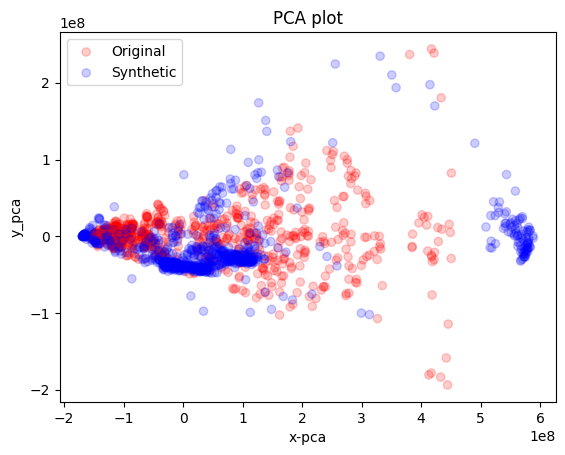

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 11686583.834261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.300720
[t-SNE] KL divergence after 300 iterations: 1.180277


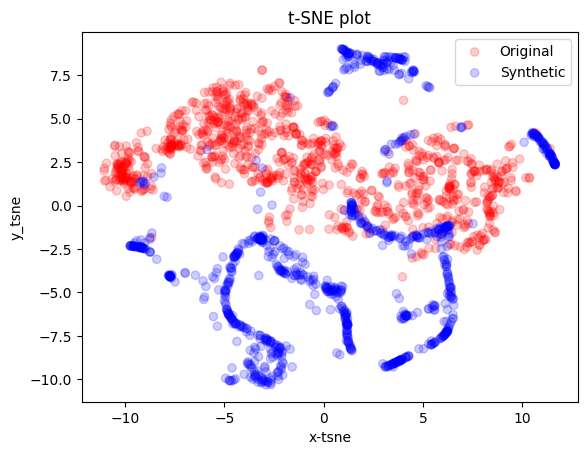

In [32]:
if len_ori_data_n < len_gen_data_n:
    visualization(ori_data_x_loaded_n, generated_data_x_loaded_n[:len(ori_data_x_loaded_n)], 'pca')
    visualization(ori_data_x_loaded_n, generated_data_x_loaded_n[:len(ori_data_x_loaded_n)], 'tsne')
else:
    visualization(ori_data_x_loaded_n[:len(generated_data_x_loaded_n)], generated_data_x_loaded_n, 'pca')
    visualization(ori_data_x_loaded_n[:len(generated_data_x_loaded_n)], generated_data_x_loaded_n, 'tsne')

## Crisis

In [33]:
len_ori_data_c = len(ori_data_x_loaded_c)
len_gen_data_c = len(generated_data_x_loaded_c)

### 1. Discriminative score

In [37]:
discriminative_score = list()
for _ in range(metric_iteration):
  if len_ori_data_c > len_gen_data_c:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_c[:len_gen_data_c], generated_data_x_loaded_c)
  else:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_c, generated_data_x_loaded_c[:len_ori_data_c])
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Discriminative score: 0.0


### 2. Predictive score

In [38]:
predictive_score = list()
for _ in range(metric_iteration):
  if len_ori_data_c > len_gen_data_c:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_c[:len_gen_data_c], generated_data_x_loaded_c)
  else:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_c, generated_data_x_loaded_c[:len_ori_data_c])
  predictive_score.append(temp_disc)

print('predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

predictive score: 64.2156


### 3. Visualisation

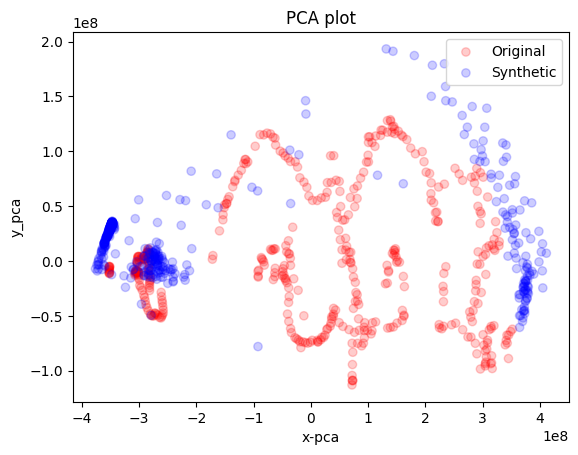

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 904 samples in 0.001s...
[t-SNE] Computed neighbors for 904 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 904 / 904
[t-SNE] Mean sigma: 9232309.373507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.235146
[t-SNE] KL divergence after 300 iterations: 0.613933


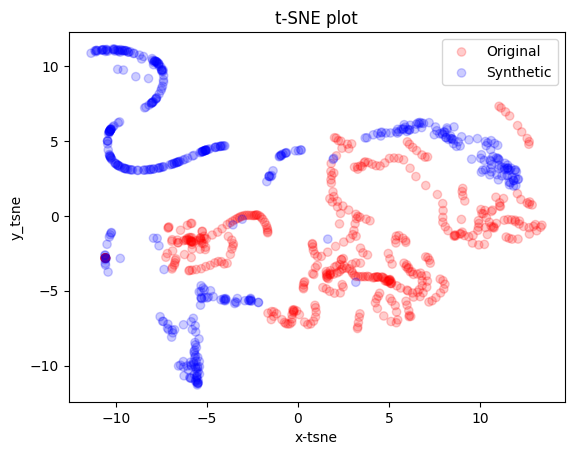

In [34]:
if len_ori_data_c < len_gen_data_c:
    visualization(ori_data_x_loaded_c, generated_data_x_loaded_c[:len(ori_data_x_loaded_c)], 'pca')
    visualization(ori_data_x_loaded_c, generated_data_x_loaded_c[:len(ori_data_x_loaded_c)], 'tsne')
else:
    visualization(ori_data_x_loaded_c[:len(generated_data_x_loaded_c)], generated_data_x_loaded_c, 'pca')
    visualization(ori_data_x_loaded_c[:len(generated_data_x_loaded_c)], generated_data_x_loaded_c, 'tsne')

## Volatile

In [35]:
len_ori_data_v = len(ori_data_x_loaded_v)
len_gen_data_v = len(generated_data_x_loaded_v)

### 1. Discriminative Score

In [39]:
discriminative_score = list()
for _ in range(metric_iteration):
  if len_ori_data_v > len_gen_data_v:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_v[:len_gen_data_v], generated_data_x_loaded_v)
  else:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_v, generated_data_x_loaded_v[:len_ori_data_v])
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Discriminative score: 0.0


### 2. Predictive Score

In [40]:
predictive_score = list()
for _ in range(metric_iteration):
  if len_ori_data_v > len_gen_data_v:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_v[:len_gen_data_v], generated_data_x_loaded_v)
  else:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_v, generated_data_x_loaded_v[:len_ori_data_v])
  predictive_score.append(temp_disc)

print('predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

predictive score: 45.7667


### 3. Visualisation

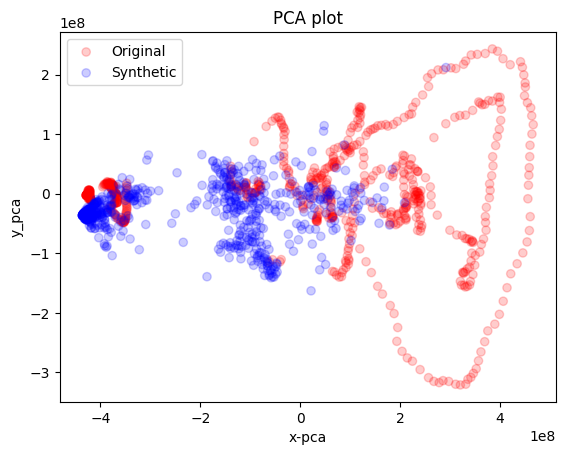

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1328 samples in 0.001s...
[t-SNE] Computed neighbors for 1328 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1328
[t-SNE] Computed conditional probabilities for sample 1328 / 1328
[t-SNE] Mean sigma: 12841313.780193
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.783508
[t-SNE] KL divergence after 300 iterations: 0.947759


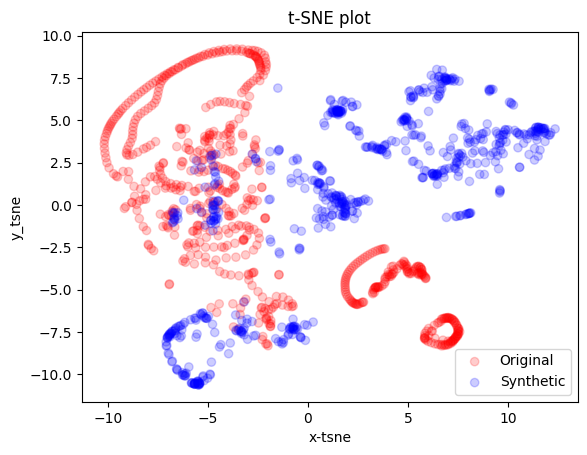

In [36]:
if len_ori_data_v < len_gen_data_v:
    visualization(ori_data_x_loaded_v, generated_data_x_loaded_v[:len(ori_data_x_loaded_v)], 'pca')
    visualization(ori_data_x_loaded_v, generated_data_x_loaded_v[:len(ori_data_x_loaded_v)], 'tsne')
else:
    visualization(ori_data_x_loaded_v[:len(generated_data_x_loaded_v)], generated_data_x_loaded_v, 'pca')
    visualization(ori_data_x_loaded_v[:len(generated_data_x_loaded_v)], generated_data_x_loaded_v, 'tsne')